# Setup

In [1]:
from joblib import dump, load
import numpy as np
from numpy import nan
from pprint import pprint
import matplotlib.pyplot as plt
import tldextract

# Load imputer, scalar and model

In [2]:
imp = load('finalized_imputer.joblib')
scaler = load('finalized_scaler.joblib')
model = load('finalized_model.joblib')

# Load phishing database

In [3]:
with open("data/urlinfo_2019-01-21_69366", "r", encoding='utf-8') as f:
    data_db = eval(f.read())

Xdb = np.array([d['feat'] for d in data_db])
ydb = np.array([d['target'] for d in data_db])
# ignore redirected
feat_labels = np.concatenate((data_db[0]['feat_labels'][0:8], data_db[0]['feat_labels'][9:16]), axis=0)
Xdb = np.concatenate((Xdb[:,0:8], Xdb[:,9:16]), axis=1)
print(feat_labels)
print("# features: ", len(feat_labels))
print("# Xdb: ", len(Xdb))
print("# ydb: ", len(ydb))
pprint(Xdb[:2])
pprint(ydb[:2])

print("# archived true: ", len([x for x in Xdb if x[0]==1]))
print("# years_active: ", len([x for x in Xdb if not np.isnan(x[1])]))
print("# years_inactive: ", len([x for x in Xdb if x[2]<=1]))
print("# captures: ", len([x for x in Xdb if not np.isnan(x[3])]))
print("# archive_redirected true: ", len([x for x in Xdb if x[4]==1]))
print("# freenom tld true: ", len([x for x in Xdb if x[5]==1]))
print("# wildcard_subdomain true: ", len([x for x in Xdb if x[6]==1]))
print("# reachable true: ", len([i for i, x in enumerate(Xdb) if x[7]==1]))
print("# blocked true: ", len([x for x in Xdb if x[8]==1]))
print("# alexa_rank true: ", len([x for x in Xdb if x[9]>-1]))
print("# brandname >80: ", len([x for x in Xdb if x[-1]>80]))
#print([i for i, x in enumerate(Xtrain) if x[8]==1])
#print(data_train[72])

['archived' 'years_active' 'years_inactive' 'num_captures'
 'archive_redirected_domain' 'freenom_tld' 'wildcard_subdomain'
 'reachable' 'blocked' 'alexa_rank' 'ratio_longest_word' 'contain_digit'
 'contain_dash' 'name_len' 'brandname_partialratio']
# features:  15
# Xdb:  69366
# ydb:  69366
array([[ 1.        , 10.        ,  1.        , 11.        ,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        ,         nan,
         0.4       ,  0.        ,  1.        , 11.        , 54.        ],
       [ 1.        , 14.        ,  1.        , 44.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,         nan,
         0.33333333,  0.        ,  0.        ,  5.        , 60.        ]])
array([-1, -1])
# archived true:  40463
# years_active:  36358
# years_inactive:  33021
# captures:  36358
# archive_redirected true:  4718
# freenom tld true:  1858
# wildcard_subdomain true:  10004
# reachable true:  41906
# blocked true:  1812
# alexa_rank true: 

# Normalize and Impute

In [4]:
Xdb = imp.transform(Xdb)
Xdb = scaler.transform(Xdb)
print(Xdb[:2])

[[ 1.19764085e+00  1.08579927e+00  4.72918171e-02 -9.34425768e-02
  -5.72172343e-01 -3.07368802e-01  3.28397362e+00  1.20591004e+00
  -4.64438203e-01  1.36976577e-13  7.66853940e-01 -3.85667598e-01
   1.53313085e+00 -3.53419090e-01 -8.87921901e-01]
 [ 1.19764085e+00  2.17914931e+00  4.72918171e-02 -9.13356557e-02
  -5.72172343e-01 -3.07368802e-01 -3.04509145e-01  1.20591004e+00
  -4.64438203e-01  1.36976577e-13  1.36535252e-01 -3.85667598e-01
  -6.52260048e-01 -1.16607493e+00 -4.61632072e-01]]


# Predict

In [5]:
ydb_pred = model.predict(Xdb)
ydb_proba = model.predict_proba(Xdb)
#print(sorted(Xpredict_proba[:,0]))

In [6]:
print("# 2nd level domains:", len(ydb_pred))
print("# compromised, hacked:", len([x for x in ydb_pred if x==1]))
print("# malicious, owned:", len([x for x in ydb_pred if x==0]))
print("% compromised, hacked:", len([x for x in ydb_pred if x==1])/len(ydb_pred))
print("% malicious, owned:", len([x for x in ydb_pred if x==0])/len(ydb_pred))

# 2nd level domains: 69366
# compromised, hacked: 50781
# malicious, owned: 18585
% compromised, hacked: 0.7320733500562235
% malicious, owned: 0.26792664994377646


# Prob analysis

In [7]:
def plotFractionalGraph(x, y, xlabel="", xmin=0, xmax=4000):
    print(y)
    print(x)

    ax = plt.subplot()
    ax.plot(x, y)

    plt.xlabel(xlabel)
    plt.ylabel("Fraction of Domains")
    #plt.axis([xmin, xmax, 0, 1])
    plt.grid(True, linestyle='dotted')

    plt.show()

In [8]:
def fractionalGraph(metric, max=100, step=5):
    cnt = 0
    fractions = [0]
    metricFractions = [0]
    while(True):
        cnt = cnt + step
        if cnt > max:
            break

        fraction = int(len(metric)*cnt/float(100))
        max_step = metric[fraction-1]
        fractions.append(cnt/float(100))
        metricFractions.append(max_step)

    plotFractionalGraph(metricFractions, fractions, xlabel="Compromised probability")

[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
[0, 0.20299419006953037, 0.24642460979406522, 0.2826478973194638, 0.38209411795041626, 0.4525808637603048, 0.5333870128523356, 0.5858993737914122, 0.6087557733513467, 0.6728441827569361, 0.7274274106856395, 0.7621330429801598, 0.7872003967875267, 0.8180086845522784, 0.8522864366605658, 0.8698579158147676, 0.8804269814899525, 0.8892363081123791, 0.8962235881187967, 0.9026560628582323, 0.9388206301415224]


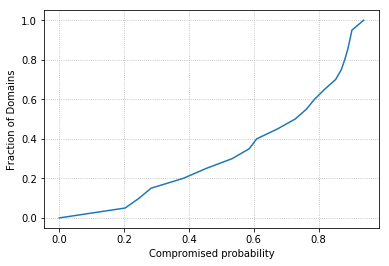

In [9]:
# distribution of probabilities
ydb_proba_sorted = sorted(ydb_proba[:,1])
fractionalGraph(ydb_proba_sorted)

# Process results

In [10]:
domain_target = dict()

for i, data in enumerate(data_db):
    info = data['info']
    domain = info[0]
    d_id = info[1]
    
    domain_target[domain] = ydb_pred[i]

#print(domain_target)

In [11]:
quarter = {"01": 'Q1', "02": 'Q1',"03": 'Q1', "04": 'Q2', "05": 'Q2', "06": 'Q2', "07": 'Q3', "08": 'Q3', "09": 'Q3', "10": 'Q4', "11": 'Q4', "12": 'Q4'}
def processList(phish_list):
    data = dict()

    for phish in phish_list:
        timestamp = phish[1]
        phish = phish[0]
        
        # get year, month
        yr, mn = timestamp.split('-')[:2]
        
        # get month, quarter
        yr_qu = '-'.join([yr, quarter[mn]])
        
        # get year-month
        yr_mn = '-'.join(timestamp.split('-')[:2])
        
        if phish:
            ext = tldextract.extract(phish)
            if ext and ext.domain and ext.suffix:
                domain = '.'.join([ext.domain, ext.suffix])
                if domain not in data:
                    data[domain] = dict()
                    data[domain]['months'] = set()
                    data[domain]['quarters'] = set()
                    data[domain]['years'] = set()
                data[domain]['months'].add(yr_mn)
                data[domain]['quarters'].add(yr_qu)
                data[domain]['years'].add(yr)

    return data

In [14]:
data = []
with open("./data/urlinfo_2019-01-21", "r", encoding='utf-8') as f:
    urlinfo = eval(f.read())
    print(len(urlinfo))
    for info in urlinfo:
        path_id = info[0]
        firstUrl = info[1]
        finalUrl = info[2]
        timestamp = info [3]
        data.append([firstUrl, timestamp])
        data.append([finalUrl, timestamp])

domain_timestamp = processList(data)

186762


In [13]:
print(domain_timestamp['buda-family.com'])

{'months': {'2016-01', '2017-01'}, 'quarters': {'2017-Q1', '2016-Q1'}, 'years': {'2016', '2017'}}


In [14]:
# we want a dict 'domain': target
# we want a dict 'domain': timestamp (latest)
# we want mal/comp buckets
monthly_bins = dict()
quarterly_bins = dict()
yearly_bins = dict()
        
for domain, target in domain_target.items():
    # get timestamp
    keys = ['months', 'quarters', 'years']
    bins = [monthly_bins, quarterly_bins, yearly_bins]
    
    for i, key in enumerate(keys):
        bn = bins[i]
        times = domain_timestamp[domain][key]
        for time in times:
            if time not in bn:
                bn[time] = [0,0]
            bn[time][target] += 1

In [15]:
pprint(monthly_bins)
pprint(quarterly_bins)
pprint(yearly_bins)

{'2016-01': [28, 336],
 '2016-02': [53, 464],
 '2016-03': [34, 358],
 '2016-04': [57, 465],
 '2016-05': [167, 1006],
 '2016-06': [263, 1327],
 '2016-07': [234, 1052],
 '2016-08': [619, 1974],
 '2016-09': [888, 2914],
 '2016-10': [1133, 3961],
 '2016-11': [913, 2703],
 '2016-12': [630, 1801],
 '2017-01': [631, 2146],
 '2017-02': [576, 1957],
 '2017-03': [893, 2965],
 '2017-04': [749, 2701],
 '2017-05': [791, 2707],
 '2017-06': [648, 2253],
 '2017-07': [505, 2060],
 '2017-08': [286, 1547],
 '2017-09': [415, 1749],
 '2017-10': [463, 1594],
 '2017-11': [384, 2029],
 '2017-12': [402, 1957],
 '2018-01': [352, 1841],
 '2018-02': [699, 2866],
 '2018-03': [904, 3228],
 '2018-04': [699, 2652],
 '2018-05': [698, 1756],
 '2018-06': [966, 1795],
 '2018-07': [674, 1243],
 '2018-08': [1240, 2018],
 '2018-09': [904, 1901],
 '2018-10': [693, 1836],
 '2018-11': [783, 2169],
 '2018-12': [531, 1429],
 '2019-01': [377, 970]}
{'2016-Q1': [106, 1022],
 '2016-Q2': [458, 2508],
 '2016-Q3': [1592, 5163],
 '2016

# Visualize

In [16]:
# we want mal/comp percentages
# Quarterly
# Yearly

In [24]:
def domainClassifPerc(timebin, title, ylabel, bin_type="", fraction=True):
    plt.figure(figsize=(8, 5))
    
    #############################################################################33
    plt.subplot(1, 1, 1)
    
    # comp, mal
    mal_comp = []
    time = sorted(timebin.keys())
    time = time[:-1]
#     if bin_type == "year":
#         time = time[:-2]
#     elif bin_type = "quarter":
#         time = time[:]
    N = len(time)
    for t in time:
        mal_comp.append(timebin[t])
    
    if fraction:
        mal = [x[0]/(x[0]+x[1]) for x in mal_comp]
        comp = [x[1]/(x[0]+x[1]) for x in mal_comp]
    else:
        mal = [x[0] for x in mal_comp]
        comp = [x[1] for x in mal_comp]
        
    print(time)
    print(mal)
    print(comp)

    ind = np.arange(N)    # the x locations for the groups
    width = 0.7       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind, comp, width)
    p2 = plt.bar(ind, mal, width,
                 bottom=comp)
    
    #print(p1[0])
    
    plt.ylabel(ylabel)
    #plt.title(title)
    plt.xticks(ind, time, rotation=50)
    #plt.yticks(np.arange(0, 71, 10))
    plt.legend((p1[0], p2[0]), ('Compromised', 'Malicious'))
    
#     plt.subplot(1, 2, 2)
#     detectors = (175, 117, 154, 111, 142)

#     #ind = np.arange(N)    # the x locations for the groups
#     #width = 0.35       # the width of the bars: can also be len(x) sequence

#     pall = plt.bar(ind, detectors, width, color='navy', label="All concepts")

#     #plt.ylabel('Scores')
#     plt.title('Number of detectors')
#     plt.xticks(ind, ('ImageNet','Baseline', 'DataAug', 'Curric', 'Curric-DataAug'), rotation=50)
#     plt.yticks(np.arange(0, 201, 50))
#     plt.legend(["all concepts"])
    
    plt.tight_layout()
    plt.show()

#### Yearly

['2016', '2017', '2018']
[4238, 5753, 8729]
[13858, 19041, 20905]


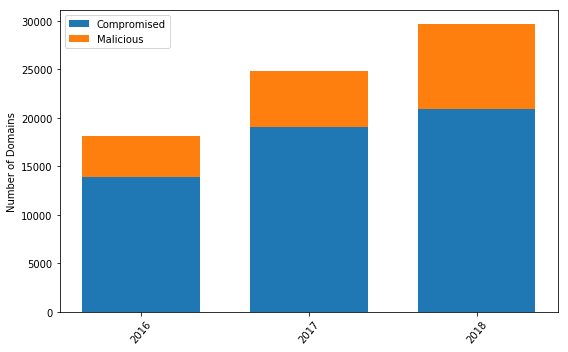

['2016', '2017', '2018']
[0.23419540229885058, 0.23203194321206744, 0.2945603023554026]
[0.7658045977011494, 0.7679680567879326, 0.7054396976445975]


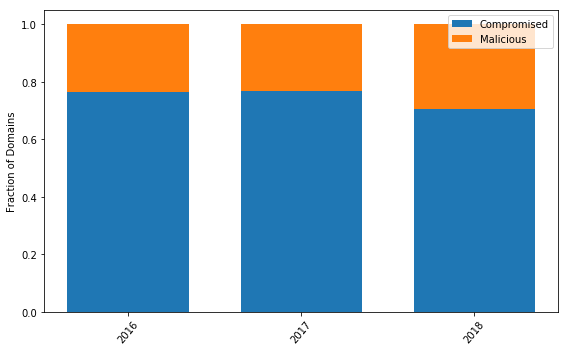

In [25]:
domainClassifPerc(yearly_bins, 'Yearly Domain Classification', 'Number of Domains', fraction=False)
domainClassifPerc(yearly_bins, 'Yearly Domain Classification', 'Fraction of Domains')

#### Quarterly

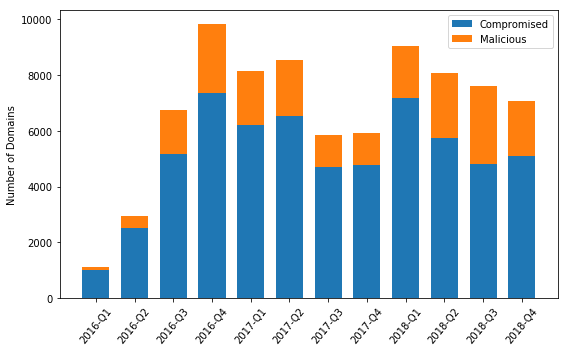

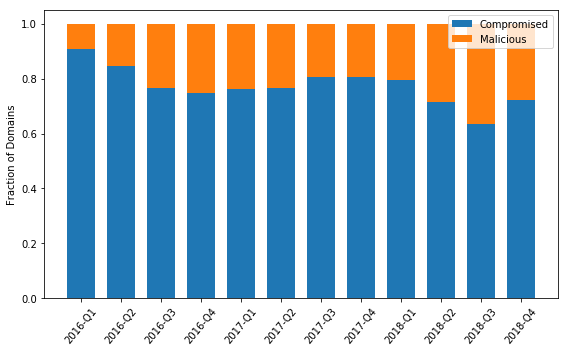

In [23]:
domainClassifPerc(quarterly_bins, 'Quarterly Domain Classification', 'Number of Domains', fraction=False)
domainClassifPerc(quarterly_bins, 'Quarterly Domain Classification', 'Fraction of Domains')

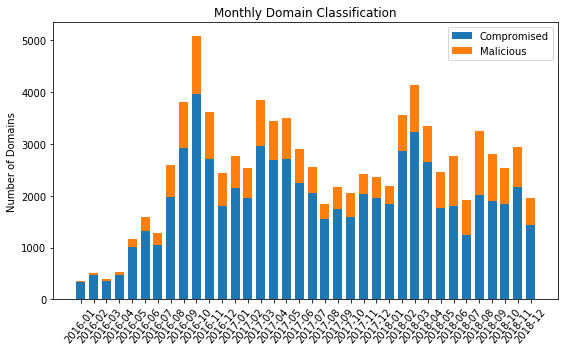

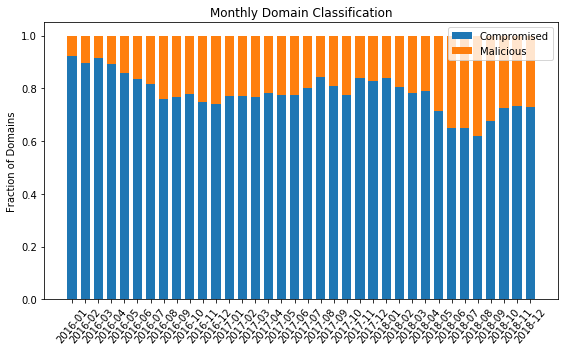

In [20]:
domainClassifPerc(monthly_bins, 'Monthly Domain Classification', 'Number of Domains', fraction=False)
domainClassifPerc(monthly_bins, 'Monthly Domain Classification', 'Fraction of Domains')

# Compromised URLs

In [31]:
comp_domains = set([data_db[i]['info'][0] for i, prob in enumerate(ydb_proba[:,1]) if prob > 0.7])
print(len(comp_domains))

36492


In [43]:
comp_urls = []
comp_urls_set = set()
with open("./data/urlinfo_2019-01-21", "r", encoding='utf-8') as f:
    urlinfo = eval(f.read())
    
    for info in urlinfo:
        path_id = info[0]
        urls = []
        urls.append(info[1])
        urls.append(info[2])
        timestamp = info[3]
        
        firstfinal = None
        for i, url in enumerate(urls):                
            if url:
                if not url.endswith('/'):
                    url+='/'
                ext = tldextract.extract(url)
                if ext and ext.domain and ext.suffix:
                    domain = '.'.join([ext.domain, ext.suffix])
                    if domain in comp_domains:
                        if i==0:
                            firstfinal = 'first'
                        elif i==1:
                            if firstfinal:
                                firstfinal = 'both'
                            else:
                                firstfinal = 'final'
        
        if firstfinal:
            comp_urls.append(info+[firstfinal])

In [44]:
print(len(comp_urls))

100325


In [45]:
with open("./data/compurls_2019-01-21", "w", encoding='utf-8') as f:
    pprint(comp_urls, f)